# Setup

In [1]:
%pip install kaggle
%pip install scikit-learn
%pip install torch torchvision
%pip install tensorboard

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


## Get the dataset from kaggle

In [2]:
import kagglehub

path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

c:\Users\rehas\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\rehas\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1


## Imports

In [3]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import confusion_matrix, classification_report
import itertools

import numpy as np
import matplotlib.pyplot as plt

import random
from PIL import Image
from pathlib import Path


torch.__version__

'2.6.0+cu118'

In [4]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## Load up the data

In [6]:
# using data augmentation on train dataset
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),       
    transforms.RandomRotation(15),               
    transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),  
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# using train dataset
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Splitting into train and test datasets
train_dataset = datasets.ImageFolder(f"{path}/Training", transform=train_transform)
test_dataset  = datasets.ImageFolder(f"{path}/Testing", transform=test_transform)

# Constants
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0.0001

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



In [7]:
class_names = train_dataset.classes
class_names   # ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

['glioma', 'meningioma', 'notumor', 'pituitary']

In [8]:
len(train_dataset), len(test_dataset) # (5712, 1311)

(5712, 1311)

### Visualisation of an Image from the Dataset

In [9]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """
    Plots a series of random images from image_paths.
    Will open n image paths from image_paths, transform them,
    and plot them side by side.

    Args:
        image_paths (list[Path]): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for reproducibility. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)

    for image_path in random_image_paths:
        with Image.open(image_path).convert("RGB") as f:
            fig, ax = plt.subplots(1, 2, figsize=(8, 4))

            # --- Original ---
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis("off")

            # --- Transformed ---
            transformed_tensor = transform(f)
            # Undo normalization for visualization (assumes mean=0.5, std=0.5)
            img = transformed_tensor.permute(1, 2, 0).numpy()
            img = img * 0.5 + 0.5  # denormalize back to [0,1]

            ax[1].imshow(img.clip(0, 1))
            ax[1].set_title(f"Transformed\nSize: {transformed_tensor.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=14)
            plt.show()

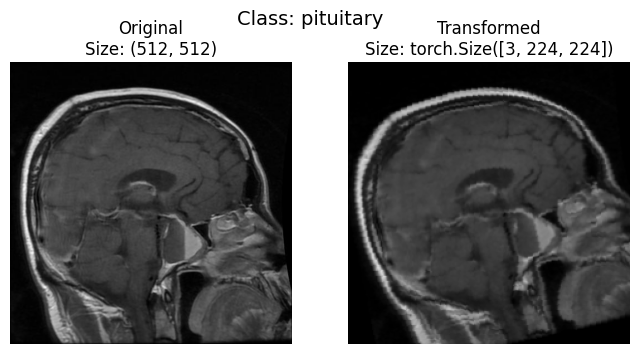

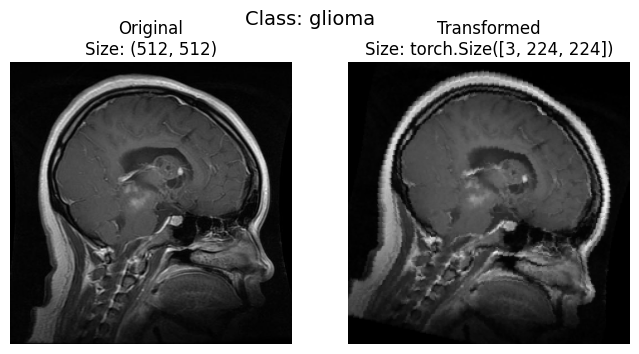

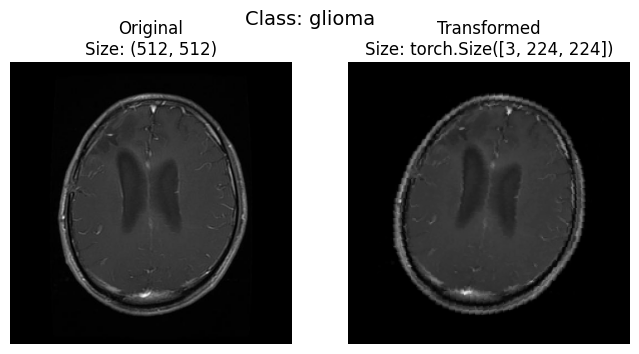

In [10]:
# Example: get all image paths from the Training set
image_path_list = list(Path(f"{path}/Training").glob("*/*.jpg"))

# Call the function
plot_transformed_images(image_path_list, transform=train_transform, n=3, seed=seed)

In [11]:
img, label = train_dataset[0][0], test_dataset[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])
Image shape: torch.Size([3, 224, 224])
Image datatype: torch.float32
Image label: 0
Label da

## Build Model, Optimiser & Loss Function

In [12]:
class BrainTumorModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units),
            nn.MaxPool2d(2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units * 2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units * 2),
            nn.Conv2d(hidden_units * 2, hidden_units * 2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units * 2),
            nn.MaxPool2d(2)
        )
        
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(hidden_units * 2, hidden_units * 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units * 4),
            nn.Conv2d(hidden_units * 4, hidden_units * 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units * 4),
            nn.MaxPool2d(2)
        )

        # Calculate the correct in_features size dynamically
        # This prevents the RuntimeError by ensuring the linear layer has the correct input shape
        with torch.inference_mode():
            dummy_input = torch.randn(1, input_shape, 224, 224)
            x = self.conv_block_1(dummy_input)
            x = self.conv_block_2(x)
            x = self.conv_block_3(x)

            # Calculate the number of features after flattening
            flattened_features = x.view(1, -1).shape[1]

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=flattened_features,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.conv_block_3(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

model_0 = BrainTumorModel(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=16, 
                  output_shape=len(train_dataset.classes)).to(device)
model_0

BrainTumorModel(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_0.parameters(), lr=LEARNING_RATE)

## Train and Evaluate Model

In [14]:
def train(model, dataloader, loss_fn, optimizer, device, epoch):
    model.train()
    total_loss, total_correct = 0, 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        preds = model(X)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()

        
        total_loss += loss.item()
        total_correct += (preds.argmax(1) == y).sum().item()

    avg_loss = total_loss / len(dataloader)
    avg_acc = total_correct / len(dataloader.dataset)

    writer.add_scalar("Loss/test", avg_loss, epoch)

    return avg_loss, avg_acc


In [15]:
def test(model, dataloader, loss_fn, device, epoch):
    model.eval()
    total_loss, total_correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            loss = loss_fn(preds, y)

            total_loss += loss.item()
            total_correct += (preds.argmax(1) == y).sum().item()

    avg_loss = total_loss / len(dataloader)
    avg_acc = total_correct / len(dataloader.dataset)
    writer.add_scalar("Loss/test", avg_loss, epoch)

    return avg_loss, avg_acc


In [16]:
model_0_results = {"train_loss": [], 
           "train_acc": [], 
           "test_loss": [],
            "test_acc": []
            }
model_0_results

{'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

In [18]:
writer = SummaryWriter('runs/experiment_1')

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model_0, train_loader, loss_fn, optimizer, device, epoch)
    test_loss, test_acc = test(model_0, test_loader, loss_fn, device, epoch)

    model_0_results["train_loss"].append(train_loss)
    model_0_results["train_acc"].append(train_acc)
    model_0_results["test_loss"].append(test_loss)
    model_0_results["test_acc"].append(test_acc)
    

    print(f"Epoch {epoch+1}/{EPOCHS}: "
          f"Train loss={train_loss:.4f}, acc={train_acc:.4f} | "
          f"Test loss={test_loss:.4f}, acc={test_acc:.4f}")


writer.close()

Epoch 1/10: Train loss=0.6500, acc=0.7602 | Test loss=0.6352, acc=0.7109
Epoch 2/10: Train loss=0.4338, acc=0.8339 | Test loss=0.4956, acc=0.8108
Epoch 3/10: Train loss=0.3601, acc=0.8633 | Test loss=0.3438, acc=0.8619
Epoch 4/10: Train loss=0.3267, acc=0.8804 | Test loss=0.2792, acc=0.8947
Epoch 5/10: Train loss=0.2990, acc=0.8873 | Test loss=0.2600, acc=0.8970
Epoch 6/10: Train loss=0.2570, acc=0.9053 | Test loss=0.2967, acc=0.8856
Epoch 7/10: Train loss=0.2465, acc=0.9069 | Test loss=0.1986, acc=0.9222
Epoch 8/10: Train loss=0.2223, acc=0.9160 | Test loss=0.2090, acc=0.9260
Epoch 9/10: Train loss=0.2123, acc=0.9223 | Test loss=0.2704, acc=0.9024
Epoch 10/10: Train loss=0.1956, acc=0.9315 | Test loss=0.2455, acc=0.9146


In [19]:
model_0_results

{'train_loss': [0.6500157376130422,
  0.43384920491112605,
  0.3600712305969662,
  0.32665522065427566,
  0.2990424745612674,
  0.2569990317026774,
  0.2465080310901006,
  0.22226507945193186,
  0.21233148127794266,
  0.19559339765045378],
 'train_acc': [0.7601540616246498,
  0.833858543417367,
  0.8632703081232493,
  0.8804271708683473,
  0.8872549019607843,
  0.9052871148459384,
  0.9068627450980392,
  0.9159663865546218,
  0.9222689075630253,
  0.9315476190476191],
 'test_loss': [0.6351882842454043,
  0.4955731068145145,
  0.3437500555406917,
  0.2791713852096688,
  0.25995348461649637,
  0.2967253549193794,
  0.1985714752227068,
  0.20903669716790318,
  0.27036055812442844,
  0.24551129680846565],
 'test_acc': [0.7109077040427155,
  0.8108314263920672,
  0.8619374523264683,
  0.8947368421052632,
  0.897025171624714,
  0.88558352402746,
  0.9221967963386728,
  0.9260106788710908,
  0.9023646071700991,
  0.9145690312738368]}

## Visualize Train and Test Results

In [20]:
def plot_loss_curves(results):
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))
    
    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

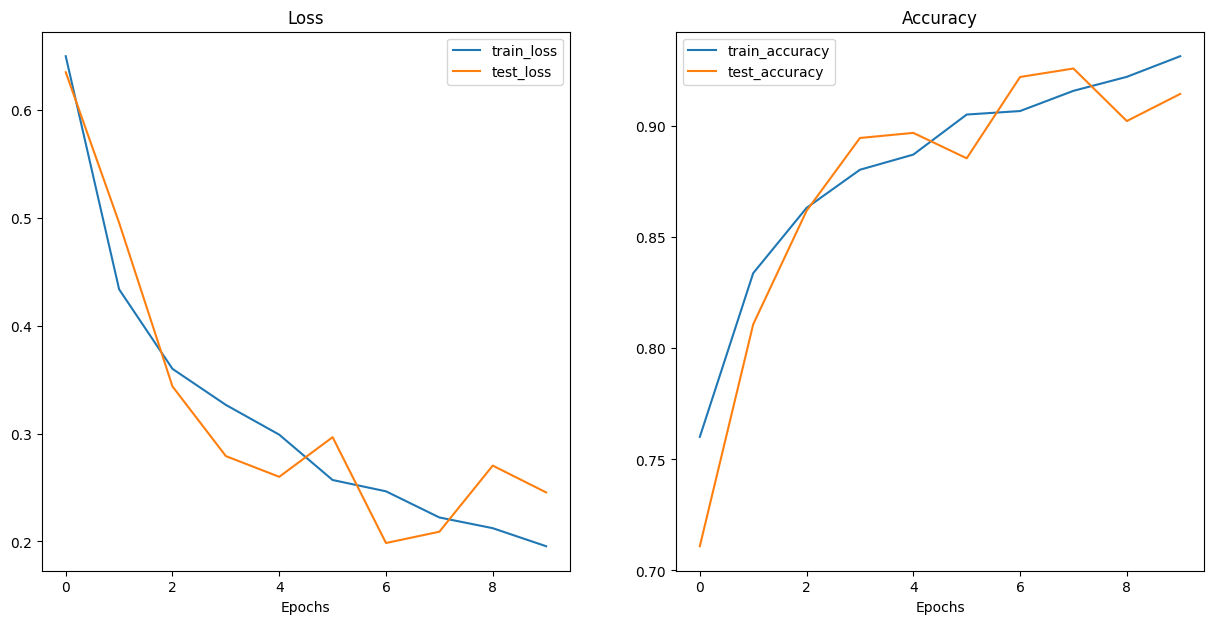

In [21]:
plot_loss_curves(model_0_results)

## Further Visualisation of the Model's Performance

Classification Report:

              precision    recall  f1-score   support

      glioma       0.88      0.95      0.92       300
  meningioma       0.91      0.76      0.83       306
     notumor       0.89      1.00      0.94       405
   pituitary       0.99      0.92      0.96       300

    accuracy                           0.91      1311
   macro avg       0.92      0.91      0.91      1311
weighted avg       0.92      0.91      0.91      1311



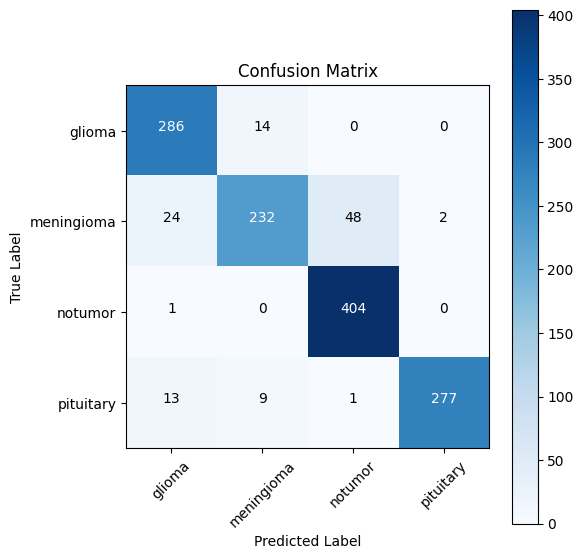

In [22]:
# Put model in eval mode
model_0.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        out = model_0(xb)
        preds = out.argmax(dim=1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(yb.cpu().numpy())

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Annotate squares
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


In [23]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))
    
    def __call__(self, input_tensor, class_idx=None):
        # Forward pass
        self.model.zero_grad()
        out = self.model(input_tensor)

        # Choose class index if not provided
        if class_idx is None:
            class_idx = out.argmax(dim=1).item()

        # Backward pass for chosen class
        score = out[:, class_idx]
        score.backward(retain_graph=True)

        # Convert stored gradients and activations to numpy
        gradients = self.gradients[0].cpu().numpy()
        activations = self.activations[0].cpu().numpy()

        # Global Average Pooling over gradients -> channel weights
        weights = np.mean(gradients, axis=(1, 2))

        # Weighted sum of activations
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i, :, :]

        # ReLU
        cam = np.maximum(cam, 0)

        # Resize CAM to match input spatial size (no cv2, use torch)
        cam_tensor = torch.from_numpy(cam).float()[None, None]  # shape (1,1,H,W)
        cam_resized = F.interpolate(
            cam_tensor,
            size=(input_tensor.shape[2], input_tensor.shape[3]),  # H,W
            mode="bilinear",
            align_corners=False
        )[0, 0]

        cam = cam_resized.numpy()

        # Normalize to [0,1]
        cam = (cam - cam.min()) / (cam.max() + 1e-8)

        return cam


c:\Users\rehas\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


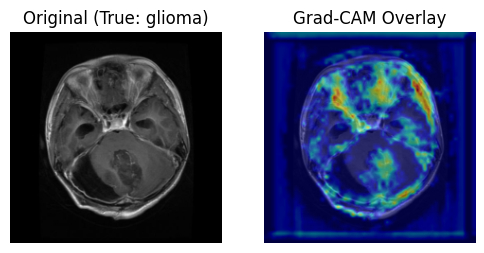

In [24]:
# pick last conv layer from your model
target_layer = None
for m in model_0.modules():
    if isinstance(m, torch.nn.Conv2d):
        target_layer = m  # last conv found
gc = GradCAM(model_0, target_layer)

# Take one test image
xb, yb = next(iter(test_loader))
img = xb[0:1].to(device)

# Generate Grad-CAM
cam = gc(img)

# Convert input tensor for visualization
inp = img[0].cpu().permute(1,2,0).numpy()
inp = (inp - inp.min()) / (inp.max() - inp.min())

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(inp)
plt.title(f"Original (True: {class_names[yb[0]]})")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(inp)
plt.imshow(cam, cmap="jet", alpha=0.5)
plt.title("Grad-CAM Overlay")
plt.axis("off")
plt.show()

## Tensorboard

Run the following code in the terminal to see the tensorboard
- ```python -m tensorboard.main --logdir=runs```

If the code above doesn't work try this instead:
- ```tensorboard --logdir=runs```